## *Setup (Locally)*

```console
# venv:
python3 -m venv mushroomobserver_venv
source mushroomobserver_venv/bin/activate
pip3 install -r requirements.txt
```

## *Artifacts:*

|**Dataset:**|[*images.tgz*](https://mo.columbari.us/static/images.tgz)|[*train.tgz*](https://mo.columbari.us/static/train.tgz)|[*test.tgz*](https://mo.columbari.us/static/test.tgz)|
|---|---|---|---|
|**Annotator json:**|[*images.json*](https://mo.columbari.us/static/images.json)|[*categories.json*](https://mo.columbari.us/static/categories.json)|[*config.json*](https://mo.columbari.us/static/config.json)|
|[**@ai.columbari.us:**](https://ai.columbari.us/classify/server)|[***Web Annotator!***](https://ai.columbari.us/annotator/photo)|[*mo_example_task.tar.gz*](https://mo.columbari.us/static/mo_example_task.tar.gz)|[*mo_example_task.zip*](https://mo.columbari.us/static/mo_example_task.zip)|


## *Preprocess: (Jupyter)*

In [1]:
from preprocess.build_images import BuildImages
from preprocess.common import *
from preprocess.load_dwca import MODwca

In [2]:
"""MODwca():
fetch & save off the gbif export
make sure we can load the dwca archive into memory:
"""
dwca = MODwca()

"""BuildImages():
functions to construct image dataset and annotator artefacts
"""
buildData = BuildImages()

buildData.write_images_json()

buildData.fetch_leaflet_tool()

buildData.fetch_online_images(_json=STATIC_PATH + "images.json")

buildData.export_tgz()

buildData.split_training_testing()

buildData.write_categories_json()

Loading row data into memory...
Read core type: http://rs.tdwg.org/dwc/terms/Occurrence! :)
Locality term is present! :)
...Loaded 75586 entries! :)
Wrote out a fresh static/images.json file! 
  exported data length: 500
  output file size: 131011 bytes
Fetching Leaflet annotator binaries...
Fetching online images from images.mushroomobserver.org...  
...this may take a while :)
Found 500 assets in static/images.json...
Writing static/images.tgz...
...
Finished writing static/images.tgz :)
full set size: 240
test set size: 291
training set size: 189
Writing static/train.tgz...
...
Finished writing static/train.tgz :)
Writing static/test.tgz...
...
Finished writing static/test.tgz :)
Wrote out a fresh static/categories.json file! 
  exported data length: 36
  output file size: 2689 bytes


## *preprocess: (Locally)*

```
python3 preprocess
```

- Fetches & saves off gbif archive to `./static/`
  - Checks the archive, tries loading it into memory etc
- Fetches Leaflet Annotator binary & licenses from [JessSullivan/MerlinAI-Interpreters](https://github.com/Jesssullivan/MerlinAI-Interpreters)
- Generates an `images.json` annotation file from the 500 assets selected by Joe & Nathan
- Generates an `categories.json` file from the 36 annotatable classes selected by Joe & Nathan
- Downloads, organizes the 500 selected assets from *images.mushroomoberver.org* at `./static/images/<category>/<id>.jpg`
  - writes out images archive
- More or less randomly divvies up testing & training image sets
  - writes out example testing/training archives; (while training it'll probably be easier to resample directly from images.tgz from keras)


## *Train: (Jupyter)*

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
dataset_url = "https://mo.columbari.us/static/images.tgz"
data_dir = tf.keras.utils.get_file('', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Read " + str(image_count) + " images into Keras!")

Read 500 images into Keras!


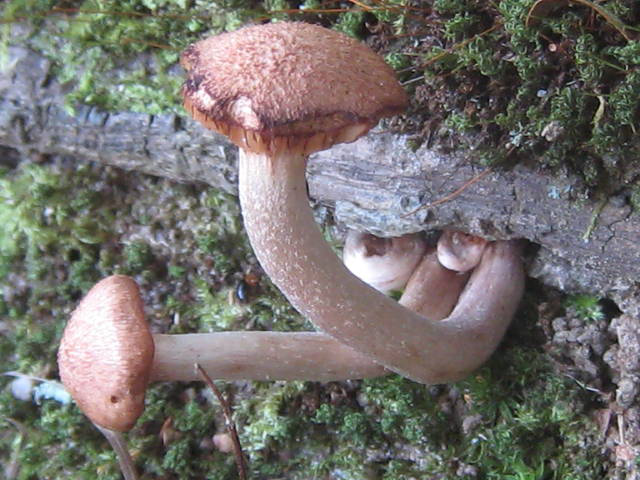

In [5]:
armillaria_tabescens = list(data_dir.glob('armillaria_tabescens/*'))
PIL.Image.open(str(armillaria_tabescens[0]))

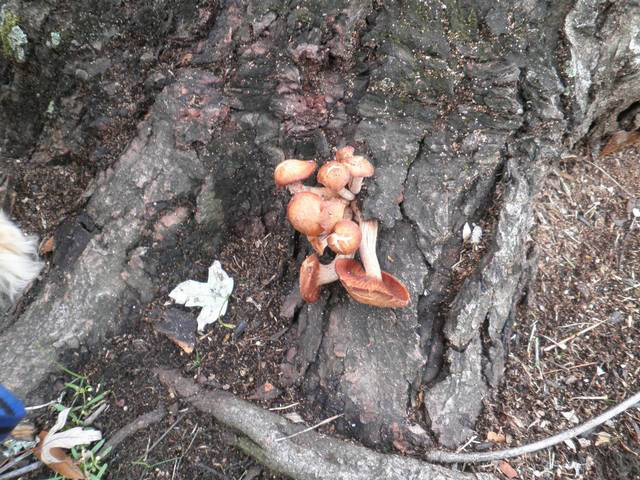

In [6]:
PIL.Image.open(str(armillaria_tabescens[1]))

load parameters:

In [7]:
batch_size = 32
img_height = 500
img_width = 375

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 36 classes.
Using 450 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 36 classes.
Using 50 files for validation.


In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)

print("Read " + str(num_classes) + " classification classes:")

x=1
for _name in class_names:
    print(str(x) + ": " + _name)
    x += 1


Read 36 classification classes:
1: agaricus_hondensis
2: amanita_volvata
3: armillaria_tabescens
4: ascocoryne_cylichnium
5: auriscalpium_andinum
6: biatora_chrysantha
7: bisporella_resinicola
8: butyriboletus_floridanus
9: chlorosplenium_chlora
10: colpoma_crispum
11: cortinarius_burlinghamiae
12: ductifera_pululahuana
13: exidiopsis_calcea
14: flammulaster_muricatus
15: gamundia_striatula
16: ganoderma_testaceum
17: gloeophyllum
18: hygrophorus_persoonii
19: hypocreopsis_rhododendri
20: hypogymnia_duplicata
21: hypogymnia_schizidiata
22: lachnellula_calyciformis
23: lentinellus_cochleatus
24: leptogium_corticola
25: leptoporus_mollis
26: lobariella_reticulata
27: muellerella_lichenicola
28: peltula_euploca
29: phaeotremella_foliacea
30: pholiota_chocenensis
31: pholiota_tuberculosa
32: pluteus_longistriatus
33: rhizomarasmius_pyrrhocephalus
34: russula_modesta
35: thamnolia_subuliformis
36: tuber_oligospermum


## *Visualize:*
first 9 images from the training dataset:

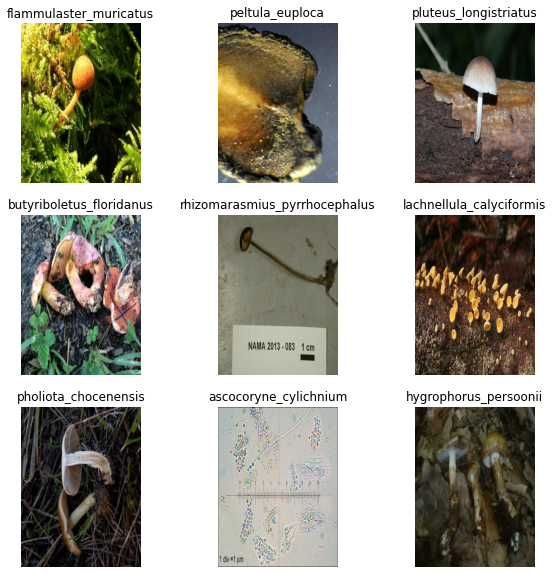

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print("Processed image batch shape: " + image_batch.shape.__str__())
    print("Processed labels batch shape: " + labels_batch.shape.__str__())
    break

Processed image batch shape: (32, 500, 375, 3)
Processed labels batch shape: (32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [15]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [16]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 500, 375, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 500, 375, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 500, 375, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 187, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 187, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 93, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 93, 64)      

In [19]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
15/15 [==============================] - 7s 174ms/step - loss: 4.5458 - accuracy: 0.0627 - val_loss: 3.5839 - val_accuracy: 0.0200
Epoch 2/15
15/15 [==============================] - 1s 96ms/step - loss: 3.4908 - accuracy: 0.0511 - val_loss: 3.7181 - val_accuracy: 0.0800
Epoch 3/15
15/15 [==============================] - 1s 95ms/step - loss: 3.2988 - accuracy: 0.1052 - val_loss: 3.4902 - val_accuracy: 0.1000
Epoch 4/15
15/15 [==============================] - 1s 95ms/step - loss: 3.2798 - accuracy: 0.0990 - val_loss: 3.5493 - val_accuracy: 0.1000
Epoch 5/15
15/15 [==============================] - 1s 95ms/step - loss: 3.1603 - accuracy: 0.1040 - val_loss: 3.3857 - val_accuracy: 0.1400
Epoch 6/15
15/15 [==============================] - 1s 95ms/step - loss: 3.1243 - accuracy: 0.1072 - val_loss: 3.4794 - val_accuracy: 0.1400
Epoch 7/15
15/15 [==============================] - 1s 96ms/step - loss: 2.9619 - accuracy: 0.1453 - val_loss: 3.3659 - val_accuracy: 0.1800
Epoch 8/15
1

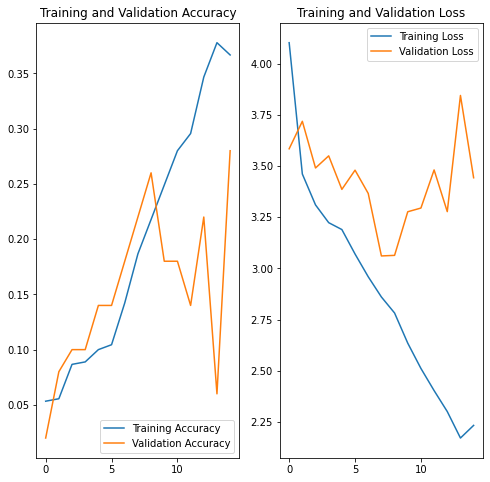

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## *Predict:*

In [21]:
tabescens_url = "https://www.mushroomexpert.com/images/kuo6/armillaria_tabescens_06.jpg"
tabescens_path = tf.keras.utils.get_file('armillaria_tabescens_06', origin=tabescens_url)

img = keras.preprocessing.image.load_img(
    tabescens_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to armillaria_tabescens with a 45.49 percent confidence.


- - - 

## *Train (Locally)*

```
python3 train
```

- Fetches, divvies & shuffles train / validation sets from within Keras using archive available at [*mo.columbari.us/static/images.tgz*](https://mo.columbari.us/static/images.tgz)
- More or less running Google's demo transfer learning training script in [`train/training_v1.py`](train/training_v1.py) as of *03/17/21*, still need to bring in training operations and whatnot from merlin_ai/ repo --> experiment with Danish Mycology Society's ImageNet v4 notes


### *Google Colab:*

- [@gvanhorn38](https://github.com/gvanhorn38/) pointed out Google Colabs's neat Juptyer notebook service will train models for free if things are small enough- I have no idea what the limits are- fiddle with their [***intro to image classification on Google Colab here***](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb), its super cool!


### *Local Jupyter:*

- One may also open and run notebooks locally like this:
  - rename ipython notebook:
  ```
  cp train/notebook/training_v1.ipynb.bak train/notebook/training_v1.ipynb
  ```
  - launch jupyter:
  ```
  jupyter notebook
  ```
  - or without authentication:
  ```
  jupyter notebook --ip='*' --NotebookApp.token='' --NotebookApp.password=''
  ```


- - -


<h4 id="structures"> </h4>


### *Structures:*


- *Leaflet Annotator `images.json` Structure:*
  - **id**: *taxonID* The MO taxon id
  - **category_id**: The binomen defined in the `./static/sample_select_assets.csv`; for directories and URIs this is converted to snake case.
  - **url**: Temporary elastic ip address this asset will be available from, just to reduce any excessive / redundant traffic to *images.mushroomobserver.org*
  - **src**: *imageURL* The asset's source URL form  Mushroom Observer
  ```
  [{
    "id": "12326",
    "category_id": "Peltula euploca",
     "url": "https://mo.columbari.us/static/images/peltula_euploca/290214.jpg"
     "src": "https://images.mushroomobserver.org/640/290214.jpg"
  }]
  ```
- *Selected asset directory structure:*
  ```
  ├── static
    ├── gbif.zip
    ├── images
    |   ...
    │   └── peltula_euploca
    │       ├── 290214.jpg
    │       ...
    │       └── 522128.jpg
    │   ...
    ├── images.json
    ├── images.tgz
    ├── js
    │   ├── leaflet.annotation.js
    │   └── leaflet.annotation.js.LICENSE.txt
    └── sample_select_assets.csv
  ...
  ```



- - -


<h4 id="notes"> </h4>


### *Notes:*


*...Progress:*  <br/>


| ... | *51%*, ...a ways to go... |
|---|---|
| ![](https://www.transscendsurvival.org/wp-content/uploads/2021/03/f1-281x300.png) | ![](https://www.transscendsurvival.org/wp-content/uploads/2021/03/f2-300x151.png) |


*Fiddling with the archive:*
- `MODwca.gbif[1].id`: Integer:  This is the Mushroom Observer taxon id, e.g.
  - `https://mushroomobserver.org/13`
  - `https://images.mushroomobserver.org/640/13.jpg`

- `MODwca.gbif[1].data:`: Dictionary: DWCA row data, e.g.
  - `MODwca.gbif[1].data['http://rs.gbif.org/terms/1.0/gbifID']` = `13`
  - `MODwca.gbif[1].data['http://rs.tdwg.org/dwc/terms/recordedBy']` = `Nathan Wilson`
